In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:


# Define the list of symbols
symbols = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "BAC"]

# Define the date range
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=365)

# Download the historical stock prices for each symbol
dfs = []
for symbol in symbols:
    df = yf.download(symbol, start_date, end_date)
    df['Symbol'] = symbol
    dfs.append(df)

# Combine the data for all symbols into a single dataframe
df = pd.concat(dfs)

# Remove rows with missing values
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
len(dfs[0])

251

## Data preprocessing

Our model will predict a day's Closing price for a stock, given information about that stock for the previous week.
To achieve this, we create "lag" features, so that each day's Close price is associated (i.e. "in the same row") as the previous day's info (close, volume, fluctuation, increase), and the day before, and the day before, etc.

In [4]:
df = dfs[0]
df.head()
df['Fluct'] = (df['High'] - df['Low'])
df['Increase'] = (df['Close'] - df['Open'])/df['Open']


for i in range(1, 8):
    df[f'Volume_{i}'] = df['Volume'].shift(i)
    df[f'Close_{i}'] = df['Close'].shift(i)
    df[f'Fluct_{i}'] = df['Fluct'].shift(i)
    df[f'Increase_{i}'] = df['Increase'].shift(i)

df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Symbol', 'Volume', 'Fluct', 'Increase'], axis=1)
df.dropna(inplace=True)
df.head()

,Close,Volume_1,Close_1,Fluct_1,Increase_1,Volume_2,Close_2,Fluct_2,Increase_2,Volume_3,...,Fluct_5,Increase_5,Volume_6,Close_6,Fluct_6,Increase_6,Volume_7,Close_7,Fluct_7,Increase_7
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-07,159.300003,83737200.0,163.169998,3.449997,-0.008025,76678400.0,166.229996,3.360001,-0.013296,79724800.0,...,2.990005,0.012633,91974200.0,164.850006,4.250000,0.006165,141147500.0,162.740005,10.850006,0.066588
2022-03-08,157.440002,96418800.0,159.300003,5.980011,-0.024853,83737200.0,163.169998,3.449997,-0.008025,76678400.0,...,4.630005,-0.009107,95056600.0,165.119995,2.990005,0.012633,91974200.0,164.850006,4.250000,0.006165
2022-03-09,162.949997,131148300.0,157.440002,7.080002,-0.008689,96418800.0,159.300003,5.980011,-0.024853,83737200.0,...,4.410004,0.013200,83474400.0,163.199997,4.630005,-0.009107,95056600.0,165.119995,2.990005,0.012633
2022-03-10,158.520004,91454900.0,162.949997,4.000000,0.009103,131148300.0,157.440002,7.080002,-0.008689,96418800.0,...,3.360001,-0.013296,79724800.0,166.559998,4.410004,0.013200,83474400.0,163.199997,4.630005,-0.009107
2022-03-11,154.729996,105342000.0,158.520004,4.410004,-0.010487,91454900.0,162.949997,4.000000,0.009103,131148300.0,...,3.449997,-0.008025,76678400.0,166.229996,3.360001,-0.013296,79724800.0,166.559998,4.410004,0.013200


## Train - validation - test split

We take 60% of our data for training, 20% for validation and 20% for testing.

In [5]:
# Split the data into train, validation, and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train, val = train_test_split(train, test_size=0.25, shuffle=False)

# Print the sizes of the train, validation, and test sets
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

X_train = train.drop(["Close"], axis=1)
y_train = train["Close"]

X_val = val.drop(["Close"], axis=1)
y_val = val["Close"]

X_test = test.drop(["Close"], axis=1)
y_test = test["Close"]

Train set size: 146
Validation set size: 49
Test set size: 49


Auxiliary function to train, test and plot the results for any sklearn model

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def show_results(model):
    model.fit(X_train, y_train)

    # Use the trained model to make predictions on the validation and test sets

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    # Plot the predicted prices and actual prices for the validation set
    plt.plot(y_val.index, y_pred_val, label="Predicted")
    plt.plot(y_val.index, y_val, label="Actual")
    plt.title("Validation Set Predictions")
    plt.legend()
    plt.show()

    print("VALIDATION RESULTS:")
    print(f'Mean absolute error: {mean_absolute_error(y_val, y_pred_val)}')
    print(f'Mean squared error: {mean_squared_error(y_val, y_pred_val)}')
    print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_val, y_pred_val)}')
    print(f'R2 score: {r2_score(y_val, y_pred_val)}')

    # Plot the predicted prices and actual prices for the test set
    plt.plot(y_test.index, y_pred_test, label="Predicted")
    plt.plot(y_test.index, y_test, label="Actual")
    plt.title("Test Set Predictions")
    plt.legend()
    plt.show()

    print("TEST RESULTS:")
    print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred_test)}')
    print(f'Mean squared error: {mean_squared_error(y_test, y_pred_test)}')
    print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred_test)}')
    print(f'R2 score: {r2_score(y_test, y_pred_test)}')

    diff = (y_pred_test[-1] - y_test[-1]) / y_test[-1]

    if(diff > 0.02):
        print("The stock will rise by more than 2%, you might wanna buy some of it now")
    elif(diff < -0.02):
        print("The stock will fall by more than 2%, you should probably sell now")
    else:
        print("No major change in stock price, it's safe to hold for now")

## Linear regression:

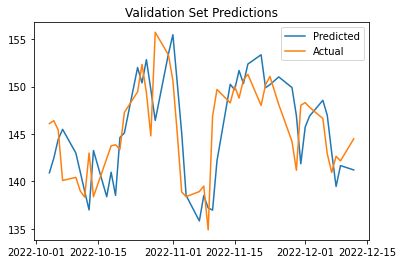

VALIDATION RESULTS:
Mean absolute error: 3.3110933741702917
Mean squared error: 16.443508566873025
Mean absolute percentage error: 0.02278885541896205
R2 score: 0.24041194668494692


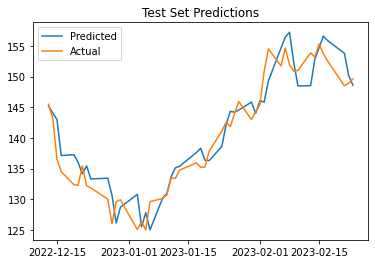

TEST RESULTS:
Mean absolute error: 2.384847763027907
Mean squared error: 8.844774217561268
Mean absolute percentage error: 0.017086733227385725
R2 score: 0.8995656953881502
No major change in stock price, it's safe to hold for now


In [7]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
show_results(reg)

## Random Forest:

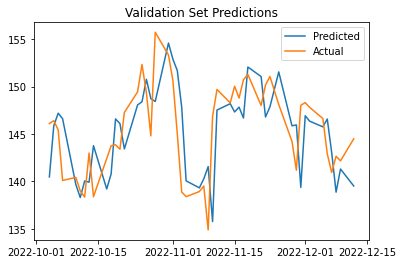

VALIDATION RESULTS:
Mean absolute error: 3.210987502117547
Mean squared error: 16.256856550621475
Mean absolute percentage error: 0.02214471049393521
R2 score: 0.2490341115407777


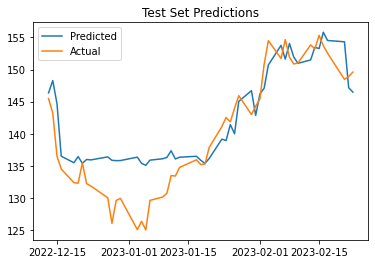

TEST RESULTS:
Mean absolute error: 3.488279540392816
Mean squared error: 19.824984801307007
Mean absolute percentage error: 0.025757831100645872
R2 score: 0.7748830537125051
The stock will fall by more than 2%, you should probably sell now


In [8]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
show_results(reg)

## XGB Regressor:

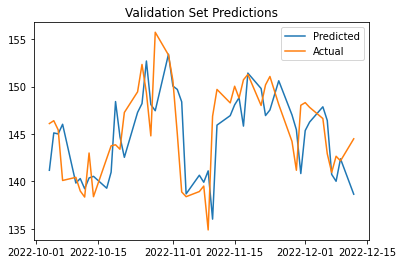

VALIDATION RESULTS:
Mean absolute error: 3.020040897305813
Mean squared error: 15.190559189957114
Mean absolute percentage error: 0.020775141010690872
R2 score: 0.2982904325472163


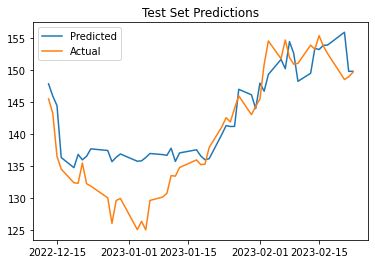

TEST RESULTS:
Mean absolute error: 3.6466015522799675
Mean squared error: 22.19558395963475
Mean absolute percentage error: 0.02696277147617271
R2 score: 0.747964392803405
No major change in stock price, it's safe to hold for now


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor()
show_results(reg)

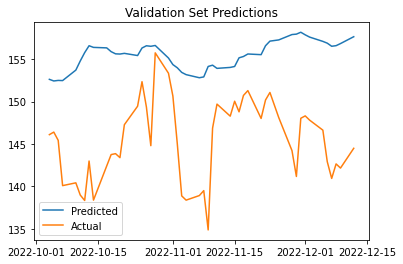

VALIDATION RESULTS:
Mean absolute error: 10.12695264655449
Mean squared error: 123.30580930382372
Mean absolute percentage error: 0.07069361954950817
R2 score: -4.69596319852435


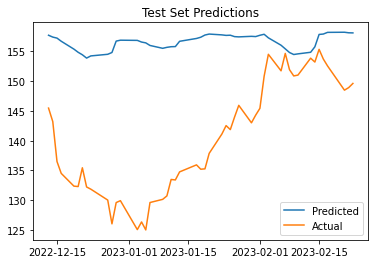

TEST RESULTS:
Mean absolute error: 16.089547625799806
Mean squared error: 341.7931948636606
Mean absolute percentage error: 0.11937444715562559
R2 score: -2.8811348942109305
The stock will rise by more than 2%, you might wanna buy some of it now


In [10]:
from sklearn.svm import SVR
reg = SVR()
show_results(reg)

We'll take Linear Regression, our best performing model, to verify if the stock is expected to increase tomorrow.

In [11]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_test = reg.predict(X_test)

The closing price of the stock on our last recorded day was:

In [12]:
y_test[-1]

149.61000061035156

## Bonus

Creating a csv in the format that is required by AWS Forecast

In [13]:
# exporting apple data to csv
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=365)
df = yf.download("AAPL", start_date, end_date)


df['timestamp'] = df.index
df['item_id'] = np.arange(len(df))
df['target_value'] = df['Close']

df = df.drop(['Close', 'Adj Close'], axis=1)

df.head()

# df.to_csv('apple_stock.csv')

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Volume,timestamp,item_id,target_value
Date,,,,,,,
2022-02-24,152.580002,162.850006,152.000000,141147500,2022-02-24,0,162.740005
2022-02-25,163.839996,165.119995,160.869995,91974200,2022-02-25,1,164.850006
2022-02-28,163.059998,165.419998,162.429993,95056600,2022-02-28,2,165.119995
2022-03-01,164.699997,166.600006,161.970001,83474400,2022-03-01,3,163.199997
2022-03-02,164.389999,167.360001,162.949997,79724800,2022-03-02,4,166.559998
